## Домашнее задание 11
1. Возьмите MNIST, обучите на нем сетку (LeNet)
2. Возьмите какую-нить картинку (из mnist’а)
3. Обучите шум, который при добавлении к оригинальной картинке, заставит ее ошибаться в пользу другого класса

In [35]:
import torch as tr
import torch.nn as nn
import torchvision as trv
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import time
import numpy as np

In [2]:
BATCH_SIZE=256

In [7]:
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ]))
test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ]))

train_it = tr.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_it = tr.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
dev = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')
print(f"work on {(tr.cuda.get_device_name() if dev.type == 'cuda' else 'cpu')}")

work on Tesla T4


### TRAINING

In [11]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [13]:
model = Net().to(dev)

In [14]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = tr.Tensor([0]).to(dev), 0
    net.eval()
    for X, y in data_iter():
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [16]:
def train(net, train_iter, test_iter, trainer, num_epochs, dev, PATH):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, q, acc_sum, start = 0.0, 0.0, 0, 0, 0.0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
#             print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
#                 (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0], l.item()))
        net.eval()

        for X, y in test_iter:
            X, y = X.to(dev), y.to(dev)
            acc_sum += (net(X).argmax(axis=1) == y).sum()
            q += y.shape[0]
        test_acc = acc_sum.item() / q
    
#         test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))
        tr.save(model.state_dict(), PATH)

In [28]:
lr, num_epochs = 0.001, 10
trainer = tr.optim.Adam(model.parameters(), lr=lr)
train(model, train_it, test_it, trainer, num_epochs, dev, "net.pth")

epoch 1, loss 0.1890, train acc 0.946, test acc 0.982, time 6.2 sec
epoch 2, loss 0.0548, train acc 0.983, test acc 0.986, time 6.1 sec
epoch 3, loss 0.0433, train acc 0.987, test acc 0.987, time 6.1 sec
epoch 4, loss 0.0364, train acc 0.989, test acc 0.988, time 6.2 sec
epoch 5, loss 0.0312, train acc 0.991, test acc 0.989, time 6.1 sec
epoch 6, loss 0.0269, train acc 0.992, test acc 0.989, time 6.2 sec
epoch 7, loss 0.0247, train acc 0.993, test acc 0.988, time 6.2 sec
epoch 8, loss 0.0209, train acc 0.994, test acc 0.988, time 6.2 sec
epoch 9, loss 0.0194, train acc 0.994, test acc 0.990, time 6.5 sec
epoch 10, loss 0.0160, train acc 0.995, test acc 0.990, time 8.1 sec


### FGSM

In [29]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "net.pth"

In [30]:
# MNIST Test dataset and dataloader declaration
test_loader = tr.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

# Initialize the network
model = Net().to(dev)

# Load the pretrained model
model.load_state_dict(tr.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [32]:
# Load the pretrained model
model.load_state_dict(tr.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [33]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = tr.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [36]:
def test(model, device, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(dev), target.to(dev)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [38]:
# Run Attack
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, dev, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9897 / 10000 = 0.9897
Epsilon: 0.05	Test Accuracy = 9396 / 10000 = 0.9396
Epsilon: 0.1	Test Accuracy = 7823 / 10000 = 0.7823
Epsilon: 0.15	Test Accuracy = 5325 / 10000 = 0.5325
Epsilon: 0.2	Test Accuracy = 3168 / 10000 = 0.3168
Epsilon: 0.25	Test Accuracy = 1786 / 10000 = 0.1786
Epsilon: 0.3	Test Accuracy = 1002 / 10000 = 0.1002


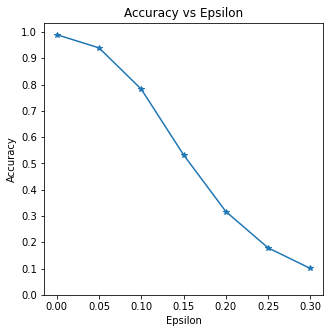

In [39]:
# Results
# Accuracy vs Epsilon
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

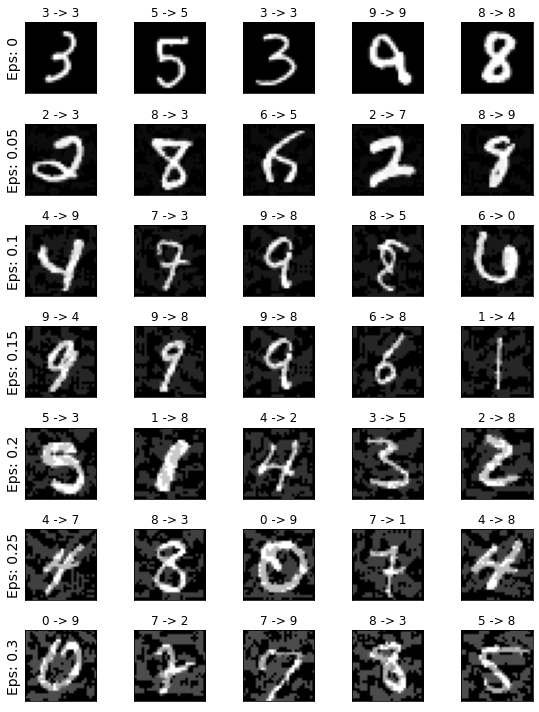

In [40]:
# Plot several examples of adversarial samples at each epsilon

cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()